In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from dataUtils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import dataUtils as du

In [2]:
path_base = "../Data/"
a = 100 #acceleration in steps
hz = 30
samples = 3 #steps in gridsearch
stepsize = 20

num_meta_rows = 6

#load all data
df = du.load_dataset(a,samples,stepsize,path_base)
#print(df.head)

# Change rotations to accurate coordinate system and make translations relative to frame 0
df = du.fixCoordinates(df)
#print(df.head)

#get valid frames (frames without wobeling/ocscilation)
start_offset = 65 #(frame before action)
wanted_frames = samples ** 6 #amount of frames to extract
frame_offset = 2*hz #time between moves
spacing = 10 #how many previous frames that have to be still
t_eps = 0.5 #translational error
r_eps =0.5 #rotational error

df_valid, valid_idx = du.getValidFrames(df,wanted_frames,frame_offset,start_offset,spacing,t_eps,r_eps)

#load tagets
comb_list = du.getGridsearchCableLengths(stepsize)
comb_list = du.getValidTargets(comb_list,valid_idx)

TOTAL FRAMES: 729 (729)
INVALID FRAMES: 0, VALID FRAMES: 729


In [3]:
seed = 42
# Assuming df is your pandas DataFrame
# Selecting features from column index 2 to 7 (exclusive of 8)
X = df_valid.iloc[:, 2:8].values

# Assuming your output targets are in the columns from index 8 onwards
Y = np.array(comb_list)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=seed)

# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=seed)

# Specify the number of folds for cross-validation
k_folds = 5

# Initialize the KFold cross-validator
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize list to store validation MSE scores
validation_mse_scores = []

# Iterate over each fold
for train_index, val_index in kf.split(X_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Fit the model on the training data
    random_forest.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation set
    y_pred = random_forest.predict(X_val_fold)
    
    # Compute MSE for this fold
    mse = mean_squared_error(y_val_fold, y_pred)
    validation_mse_scores.append(mse)

# Print the validation MSE scores
print("Validation MSE scores:", validation_mse_scores)
print("Mean Validation MSE:", np.mean(validation_mse_scores))
print("Std Validation MSE:", np.std(validation_mse_scores))

Validation MSE scores: [51.16876344086021, 55.18381720430108, 52.069569892473105, 54.30768817204301, 51.01501355013551]
Mean Validation MSE: 52.74897045196258
Std Validation MSE: 1.6925321559031898


In [4]:
#Regularize the input data
def steps_to_mm(steps):
  return steps *15*np.pi/200

col = ["X_trans", "Y_trans", "Z_trans", "X_rot", "Y_rot", "Z_rot"]

#max_dist = steps_to_mm(100)
#min_dist = steps_to_mm(-100)

#based
#max_vals = [20, 20, 20, 15, 15, 15]#[2,2.5,10,7.5,]
#min_vals = [-20, -20, -20, -15, -15, -15]#[-2,-7,-3.5,-11]
X_norm = df_valid[col].copy()
# #print(X_norm.head)
# #print(X_norm)


for i in range(6):
  #X_norm[col[i]] = (X_norm[col[i]]-X_norm[col[i]].min()) / (X_norm[col[i]].max()-X_norm[col[i]].min())
  #X_norm[col[i]] =X_norm[col[i]] - X_norm[col[i]].mean()
  # mean_value = X_norm[col[i]].mean()
  # std_value = X_norm[col[i]].std()

  # # Z normalize the column
  # X_norm[col[i]] = (X_norm[col[i]] - mean_value) / std_value
  # X_norm[col[i]] = X_norm[col[i]] - X_norm[col[i]].mean()
  X_norm[col[i]] = 2 * (X_norm[col[i]] - X_norm[col[i]].min()) / (X_norm[col[i]].max() - X_norm[col[i]].min()) - 1

#print(X_norm)
print(X_norm.max())
print(X_norm.min())
#print(df_valid.min())
#X_norm = (X - min_vals) / (max_vals-min_vals)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_norm.values, Y, test_size=0.15, random_state=seed)

X_trans    1.0
Y_trans    1.0
Z_trans    1.0
X_rot      1.0
Y_rot      1.0
Z_rot      1.0
dtype: float64
X_trans   -1.0
Y_trans   -1.0
Z_trans   -1.0
X_rot     -1.0
Y_rot     -1.0
Z_rot     -1.0
dtype: float64


In [5]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        #self.bn1 = nn.BatchNorm1d(6)
        self.fc1 = nn.Linear(input_size, hidden_size)
        #self.bn2 = nn.BatchNorm1d(30)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.bn3 = nn.BatchNorm1d(30)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        #self.bn4 = nn.BatchNorm1d(30)
        self.dropout3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(hidden_size, output_size)

        #self.fc5 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        #x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        #x = self.dropout3(x)
        x = self.fc4(x)
        return x

# Define input and output sizes
input_size = 6
output_size = 6
hidden_size = 16#64
batch_size = 4
lr = 0.001
num_epochs = 500

# Create the model
model = FeedForwardNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

In [6]:
#SETUP DATALOADERS
from torch.utils.data import TensorDataset, DataLoader

def create_data_loaders(train_index, val_index):
    X_train_fold,y_train_fold = torch.tensor(X_train[train_index], dtype=torch.float32), torch.tensor(y_train[train_index], dtype=torch.float32)
    X_val_fold,y_val_fold = torch.tensor(X_train[val_index], dtype=torch.float32), torch.tensor(y_train[val_index], dtype=torch.float32)
    train_dataset = TensorDataset(X_train_fold,y_train_fold)
    val_dataset = TensorDataset(X_val_fold,y_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

# train_data_tensor = torch.tensor(X_train, dtype=torch.float32)
# targets_tensor = torch.tensor(y_train, dtype=torch.float32)
# val_data_tensor = torch.tensor(X_test, dtype=torch.float32)
# val_targets_tensor = torch.tensor(y_test, dtype=torch.float32)

# # Combine the input data and target values into a TensorDataset
# train_dataset = TensorDataset(train_data_tensor, targets_tensor)
# test_dataset = TensorDataset(val_data_tensor, val_targets_tensor)

# # Create a DataLoader for batch processing
# batch_size = 4
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

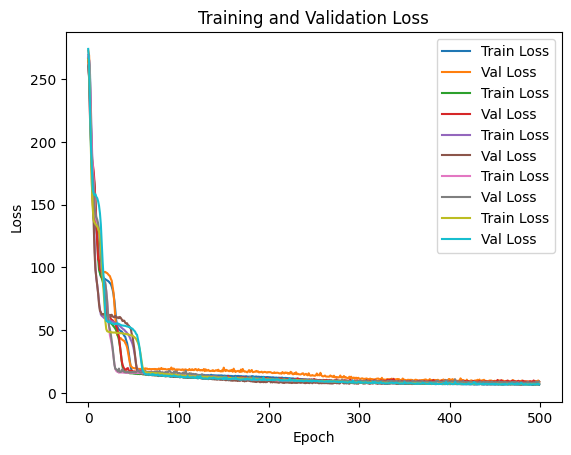

In [7]:
#TRAINING
# Lists to store training and validation losses
train_losses = []
val_losses = []
i = 0
for train_index, val_index in kf.split(X_train):


    # Initialize early stopping parameters
    # best_val_loss = np.Inf
    # patience = 15
    # counter = 0
    # Create the model
    model = FeedForwardNN(input_size, hidden_size, output_size)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed
    train_losses_fold = []
    val_losses_fold = []
    train_loader,val_loader = create_data_loaders(train_index, val_index)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        
        # Training loop
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        # Compute average training loss for the epoch
        average_train_loss = running_train_loss / len(train_loader)
        train_losses_fold.append(average_train_loss)
        
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
        
        # Compute average validation loss for the epoch
        average_val_loss = running_val_loss / len(val_loader)
        val_losses_fold.append(average_val_loss)

         # Check for improvement in validation loss
        # if running_val_loss < best_val_loss:
        #     best_val_loss = running_val_loss
        #     counter = 0
        #     # Save the best model state if needed
        #     # torch.save(model.state_dict(), 'best_model.pt')
        # else:
        #     counter += 1
        #     # If no improvement for patience epochs, stop training
        #     if counter >= patience:
        #         print(f'Early stopping at epoch {epoch}.')
        #         break
        
        # Print training and validation loss for the epoch
        print(f"Fold: {i}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}", end = "\r")
    i += 1
    train_losses.append(train_losses_fold)
    val_losses.append(val_losses_fold)

# Plot the training and validation losses
plt.figure()
for i in range(k_folds):
    plt.plot(train_losses[i], label='Train Loss')
    plt.plot(val_losses[i], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
#x[-1] for x in 

In [9]:
# # (5,100)
# #print(np.array(train_losses).shape)
# for i in range(5):
#   print(val_losses[i][-1])
# # print(train_losses[:][1])
# # print(train_losses[1])
# # print(train_losses)

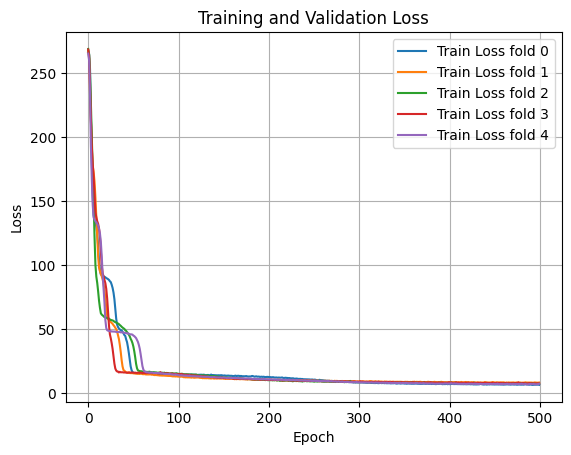

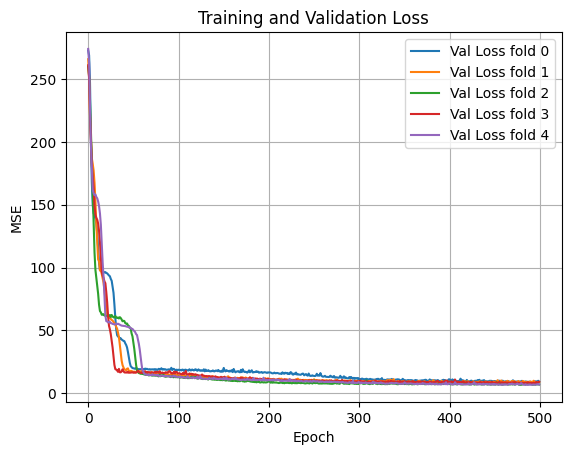

Mean Training MSE: 7.356805396464563, Mean Training STD: 0.5808345386865674
Mean Validation MSE: 8.18571047782898, Mean Validation STD: 1.0453690337252575


In [10]:
plt.figure()
for i in range(k_folds):
    plt.plot(train_losses[i], label=f'Train Loss fold {i}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure()
for i in range(k_folds):
    plt.plot(val_losses[i], label=f"Val Loss fold {i}")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()
print(f"Mean Training MSE: {np.mean(np.array(train_losses)[:,-1])}, Mean Training STD: {np.std(np.array(train_losses)[:,-1])}")
print(f"Mean Validation MSE: {np.mean(np.array(val_losses)[:,-1])}, Mean Validation STD: {np.std(np.array(val_losses)[:,-1])}")

In [11]:
np.save("data/20_new/3hid_16_neu_500epoch_p001lr_norm-11_trainloss",np.array(train_losses))
np.save("data/20_new/3hid_16_neu_500epoch_p001lr_norm-11_valloss",np.array(val_losses))

In [12]:
# # Lists to store training and validation losses

# # Create the model
# model = FeedForwardNN(input_size, hidden_size, output_size)



# # Define loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# train_data_tensor = torch.tensor(X_train, dtype=torch.float32)
# targets_tensor = torch.tensor(y_train, dtype=torch.float32)
# val_data_tensor = torch.tensor(X_test, dtype=torch.float32)
# val_targets_tensor = torch.tensor(y_test, dtype=torch.float32)
# # Combine the input data and target values into a TensorDataset
# train_dataset = TensorDataset(train_data_tensor, targets_tensor)
# test_dataset = TensorDataset(val_data_tensor, val_targets_tensor)

# # Create a DataLoader for batch processing
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     model.train()  # Set the model to training mode
#     running_train_loss = 0.0
    
#     # Training loop
#     for inputs, targets in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         running_train_loss += loss.item()
    
#     # Compute average training loss for the epoch
#     average_train_loss = running_train_loss / len(train_loader)
#     train_losses.append(average_train_loss)
    
#     # Validation loop
#     model.eval()  # Set the model to evaluation mode
#     running_val_loss = 0.0
#     with torch.no_grad():
#         for inputs, targets in val_loader:
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             running_val_loss += loss.item()
    
#     # Compute average validation loss for the epoch
#     average_val_loss = running_val_loss / len(val_loader)
#     val_losses.append(average_val_loss)
    
#     # Print training and validation loss for the epoch
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}", end = "\r")

In [13]:
# #SAVE MODEL
# model_name = "2hid_32_neu_1000epoch_p001lr"
# torch.save(model, "models/"+ model_name + ".pth")